In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from astropy.io import fits
import os
from astropy.visualization import make_lupton_rgb
from json import load

%matplotlib inline

In [2]:
def plot_image_grid(input_df, rows, cols, title=None, savepath=None, show_names=False):
    size = 3*max(rows, cols)
    fig, fr = plt.subplots(rows,cols, figsize=(15, 15))
    fr = np.ravel(fr)
    
    idc = np.random.randint(0, input_df.shape[0], rows*cols)

    # plot the images of some of these objects to see what the voters saw
    for i, name in enumerate(input_df['name'].iloc[idc]):
        object_name = name
        path = '../image/thumbnails/{}_insp.png'.format(object_name)
        image = Image.open(path)
        fr[i].imshow(image)
        
        if show_names:
            fr[i].set_title(object_name)
        fr[i].set_axis_off()


    if title:
        fig.suptitle(title)
    fig.tight_layout()
    
    if savepath:
        plt.savefig('./plots/{}.png'.format(savepath), dpi=200, bbox_inches='tight')
    plt.show()

In [3]:
def get_cols(df, cols):
    return df[cols].T.values

In [4]:
# df_votes.json is created in ./df_stacked.ipynb. 
#  Make sure to re-run that whenever we change something, 
#   otherwise we'll be working with stale data in this notebook
df_votes = pd.read_json('df_votes.json')
df = pd.read_json('df_stacked.json')

In [5]:
workflows = df['workflow_name'].unique().tolist()
print(workflows)

['Classify! Hardcore edition', 'Classify!', 'Classify on the go!']


In [6]:
hc = df.query('workflow_name == @workflows[0]')
classify = df.query('workflow_name == @workflows[1]')
onthego = df.query('workflow_name == @workflows[2]')

In [7]:
catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')

---

In [8]:
df_votes.shape[0]

6362

In [9]:
df_votes.query('RA.isnull()').shape[0]

922

---

### Inspect images of objects without properties

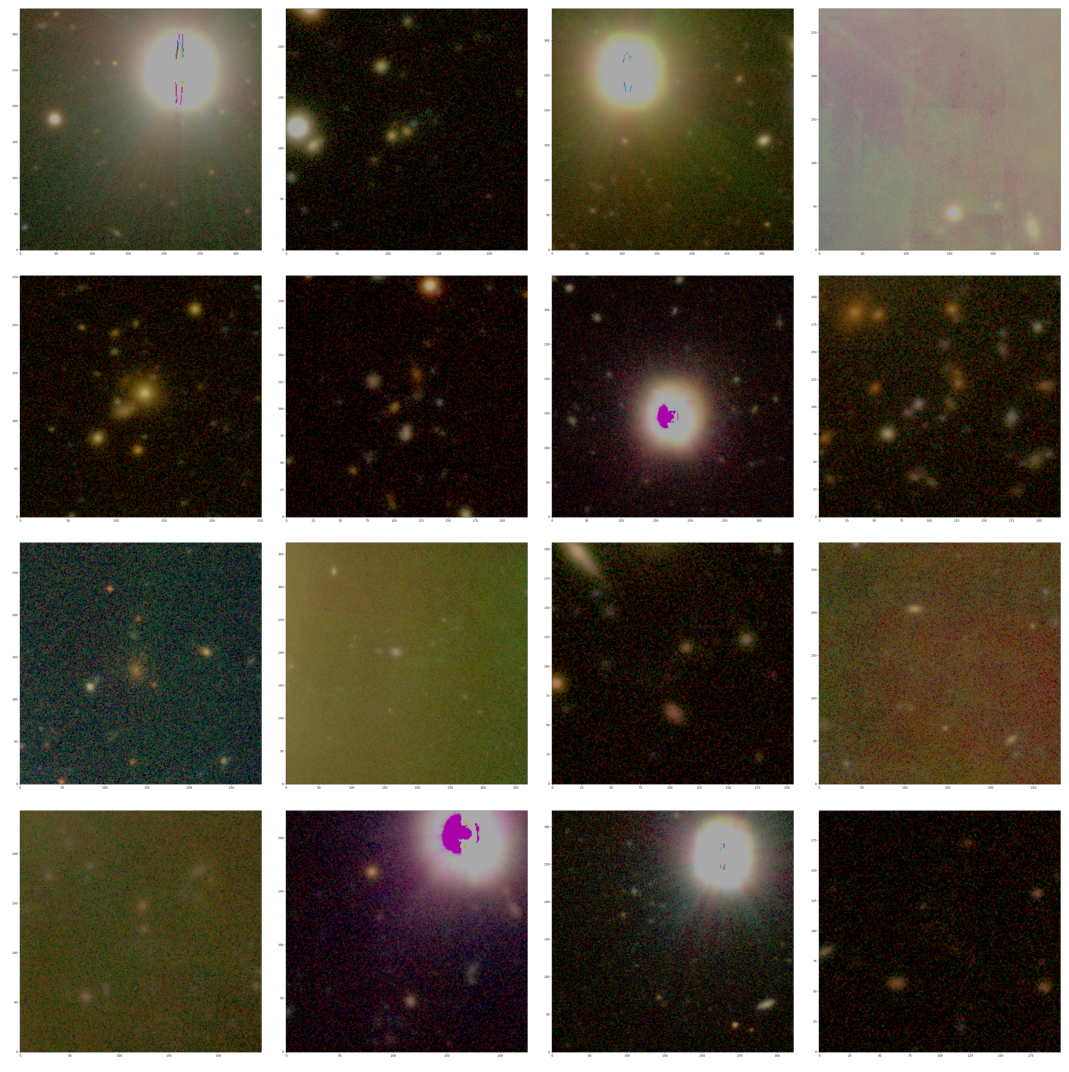

In [10]:
plot_image_grid(
    df_votes.query('RA.isnull()'), 
    4, 
    4, 
    savepath='grid 4x4 no properties'
)

### Get DES images for some of these objects

In [11]:
no_props = df_votes.query('RA.isnull()')

idc = np.random.randint(0, no_props.shape[0], 50)

names = no_props.iloc[idc][['name']].values.tolist()

In [12]:
names = [name[0] for name in names]

In [13]:
subj = df.query('Filename.isin(@names)')

def get_ra_dec(x):
    obj = list(x['subject_data'].values())[0]
    name = x['Filename']
    ra, dec = [obj.get(key) for key in ['RA', "DEC"]]
    return [name, ra, dec]

name_and_coords = subj.apply(lambda x: get_ra_dec(x), axis=1)

In [14]:
seen = []
filtered = []

for entry in name_and_coords:
    name, ra, dec = entry
    if name in seen:
        continue
    else:
        seen.append(name)
        filtered.append((name, ra, dec))

In [15]:
for entry in filtered:
    name, ra, dec = entry
    print('{}, {}'.format(ra, dec))
    
for entry in filtered:
    name, _, _ = entry
    print(name)

55.4473457336, -36.9024276733
55.9163475037, -36.8839912415
52.7663841248, -33.597278595
50.9117927551, -35.9662322998
54.3057098389, -33.9181556702
51.0077514648, -37.3156890869
50.312664032, -37.4241447449
52.8057823181, -34.9486503601
53.3126983643, -33.399230957
53.4113616943, -36.0881996155
53.0363235474, -33.5320396423
55.0341148376, -35.6254959106
53.1928520203, -33.1497688293
52.8427581787, -33.5450935364
52.2166786194, -34.9011116028
54.6380805969, -37.2337684631
51.6965751648, -37.9139938354
54.742275238, -34.7007026672
54.5912742615, -33.7192344666
55.9746322632, -36.7198104858
54.5258827209, -34.1594238281
55.4206466675, -33.3722648621
51.8303794861, -33.1700782776
51.8519668579, -35.6799316406
56.6009025574, -35.8623046875
57.5061721802, -34.0311126709
54.1826400757, -36.2607002258
55.5486526489, -36.3485641479
55.2329444885, -34.9183578491
51.6194953918, -35.2911758423
52.9240226746, -33.5520515442
57.4458312988, -37.2863349915
56.5288887024, -35.5720672607
54.3479576111,

#### From Venhola's `thesis_final_print`: use 0.0967 kpc/arcsec2 for the relation between actual size and angular size.

In [16]:
# 3kpc object
3/0.0967

r = np.sqrt((3/0.0967)/np.pi); r  # r = 3.142 arsec, so should be visible on 1 arcmin x 1arcmin tile

3.142479505274298

## Show some DES images (I don't know which objects these are)

In [17]:
base = '../image/des/_/da49938612254da086f8915bab1014f0/'

files = []
for entry in os.listdir(base):
#     print(entry)
    if not '.' in entry:
        first = os.listdir('{}/{}'.format(base, entry))[0]
        fits_file = os.listdir('{}/{}/{}'.format(base, entry, first))[0]
        
        files.append('{}/{}/{}/{}'.format(base, entry, first, fits_file))

In [18]:
data_list = []
for file in files:
    hdu_list = fits.open(file)
    data = hdu_list[0].data
    data_list.append(data)

In [19]:
no_props_paths = glob('{}/{}'.format(os.getcwd(), '../image/des/50-no-props/**/**/**/*.png'))

In [20]:
tilenames = []

for path in no_props_paths:
    stubs = path.split('\\')
    for stub in stubs:
        if stub.startswith('DES') and not '.' in stub:
            tilenames.append(stub)

In [21]:
# image size is 0.5x0.5 arcmin
base = 'fluf-not-catalogue-0.5arcmin'
fits_paths = np.array(glob('{}/{}'.format(os.getcwd(), '../image/des/{}/**/**/*.fits'.format(base))))

# this one has images of 2x2 arcmin
# fits_paths = np.array(glob('{}/{}'.format(os.getcwd(), '../image/des/fluf-not-catalogue/**/**/**/*.fits')))

In [22]:
base_dir = 'all-catalogue-1x1arcmin'
input_df = df_votes.query('name.isin(@catalogue_targets)')

def match_fits_files_to_object_names(base_dir, input_df):
    
    '''
    Unzip DES files, so that the bottom level folder (the one that contains summary.json), 
        which we'll call base_dir, is in the tree as /image/des/%base_dir%
    @param base_dir is the directory name as described above,
    @param input_df is the input dataframe from which the coordinates that were passed to the DES cutout service were taken from.
        we assume a 1:1 match, where coordinates of each object from input_df was passed once (and only once) to the DES cutout service
    '''
    
    fits_paths = np.array(glob('{}/{}'.format(os.getcwd(), '../image/des/{}/**/**/*.fits'.format(base_dir))))
    json_filepath = glob(os.path.join(os.getcwd(), '..\\image\\des', base_dir, '*.json' ))[0]
    json_summary = load(open(json_filepath))
    
    names_to_fits = {}

    for i, entry in enumerate(json_summary['cutouts']):
        files, ra, dec = [entry.get(key) for key in ["FILES", "RA", "DEC"]]
        filtered = input_df[ (np.abs(input_df['RA'] - ra) <= 1e-4) & (np.abs(input_df['DEC'] - dec) <= 1e-4)]
        if not filtered.shape[0] == 1:
            print('No singular match found for json_summary index {}, check manually'.format(i))
        else:
            names_to_fits[filtered.iloc[0]['name']] = files
            
    names_to_fits_bases = {}
    for key, val in names_to_fits.items():
        base = list(set([x[:-7] for x in val if '.png' not in x]))
        if len(base) == 1:
            names_to_fits_bases[key] = base[0]
        else:
            print(base)

    # swap keys and values to get fits_base as key, object name as value
    names_to_fits_bases = {v: k for (k, v) in names_to_fits_bases.items()}
    
    return names_to_fits_bases

In [23]:
def make_rgb(base_dir=None, input_df=None, Q=5, stretch=25, limit=None):
    if not base_dir:
        base_dir = 'fluf-not-catalogue-0.5arcmin'
    
    fits_paths = np.array(glob('{}/{}'.format(os.getcwd(), '../image/des/{}/**/**/*.fits'.format(base_dir))))
    rgbs = {}

    ps = fits_paths.copy()
    if limit:
        ps = ps[:3*limit]
        
#     if (not base_dir is None) and (not input_df is None):
    name_to_fits_dict = match_fits_files_to_object_names(base_dir, input_df)
        
    for path in ps:
        obj = path.split('\\')[-2]
        fnames_this_obj = list(filter(lambda x: obj in x.split('\\')[-2], fits_paths))
        color_paths = [list(filter(lambda x: '_{}.fits'.format(c) in x, fnames_this_obj))[0] for c in ['i', 'r', 'g']]
        i, r, g = [fits.open(p)[0].data for p in color_paths]
        rgb = make_lupton_rgb(i, r, g, Q=Q, stretch=stretch)
        
        name = name_to_fits_dict[obj]
        rgbs[name] = rgb
    return rgbs

In [24]:
rgbs = make_rgb(
    base_dir=base_dir,
    input_df=input_df,
)

In [25]:
# list taken from ./"stacked - selection cuts.ipynb"
survives_cut_not_fluffy = ['UDGcand_396','UDGcand_210','UDGcand_20','UDGcand_101','UDGcand_141','UDGcand_327','UDGcand_106','UDGcand_69','UDGcand_118','UDGcand_5','UDGcand_380','UDGcand_337','UDGcand_17','UDGcand_54','UDGcand_354','UDGcand_131','UDGcand_0','UDGcand_163','UDGcand_282','UDGcand_226','UDGcand_300','UDGcand_287','UDGcand_129','UDGcand_221','UDGcand_6776','UDGcand_6120','UDGcand_2369','UDGcand_3480','UDGcand_5222','UDGcand_5163','UDGcand_1578','UDGcand_6031','UDGcand_1302','UDGcand_4866','UDGcand_1750','UDGcand_1747','UDGcand_1451','UDGcand_1961','UDGcand_3390','UDGcand_4024','UDGcand_2424','UDGcand_1436','UDGcand_5157','UDGcand_6738','UDGcand_5698','UDGcand_6174','UDGcand_5801','UDGcand_852','UDGcand_2919','UDGcand_1654','UDGcand_2370','UDGcand_5938','UDGcand_6436','UDGcand_940','UDGcand_2137','UDGcand_3507','UDGcand_2761','UDGcand_2670','UDGcand_3269','UDGcand_3890','UDGcand_4066','UDGcand_1070','UDGcand_2191','UDGcand_1538','UDGcand_5972','UDGcand_6201','UDGcand_7174','UDGcand_5110','UDGcand_6705','UDGcand_1557','UDGcand_3848','UDGcand_1408','UDGcand_2509','UDGcand_2350','UDGcand_1820','UDGcand_6460','UDGcand_4074','UDGcand_2057','UDGcand_1489','UDGcand_2667','UDGcand_2839','UDGcand_4794','UDGcand_4214','UDGcand_2810','UDGcand_432','UDGcand_5368','UDGcand_5798','UDGcand_5260','UDGcand_5121','UDGcand_1212','UDGcand_2855','UDGcand_4725','UDGcand_3057','UDGcand_3997','UDGcand_3736','UDGcand_1571','UDGcand_5762','UDGcand_4099','UDGcand_5264','UDGcand_4463','UDGcand_684','UDGcand_5261','UDGcand_421','UDGcand_1034','UDGcand_6778','UDGcand_7127','UDGcand_5958','UDGcand_6513','UDGcand_2443','UDGcand_5323','UDGcand_5142','UDGcand_7180','UDGcand_1002','UDGcand_5361','UDGcand_5427','UDGcand_3729','UDGcand_2647','UDGcand_3296','UDGcand_4225','UDGcand_1822','UDGcand_2220','UDGcand_7068','UDGcand_653','UDGcand_1886','UDGcand_1911','UDGcand_6055','UDGcand_828','UDGcand_2363','UDGcand_2758','UDGcand_1150','UDGcand_2293','UDGcand_1194','UDGcand_691','UDGcand_6685','UDGcand_5254','UDGcand_1536','UDGcand_4703','UDGcand_3410','UDGcand_5800','UDGcand_412','UDGcand_1660','UDGcand_1653','UDGcand_1248','UDGcand_5263','UDGcand_1439','UDGcand_3866','UDGcand_2655','UDGcand_2310','UDGcand_2918','UDGcand_5045','UDGcand_1079','UDGcand_5837','UDGcand_6052','UDGcand_729','UDGcand_2876','UDGcand_2497','UDGcand_3226','UDGcand_6409','UDGcand_3127','UDGcand_1262','UDGcand_6651','UDGcand_4170','UDGcand_2182','UDGcand_4228','UDGcand_3717','UDGcand_6760','UDGcand_4617','UDGcand_6129','UDGcand_2179','UDGcand_2152','UDGcand_5577','UDGcand_4752','UDGcand_5151','UDGcand_4958','UDGcand_5073','UDGcand_1853','UDGcand_5375','UDGcand_637','UDGcand_4331','UDGcand_3043','UDGcand_682','UDGcand_2231','UDGcand_3749','UDGcand_2590','UDGcand_6852','UDGcand_1094','UDGcand_2144','UDGcand_5166','UDGcand_2068','UDGcand_2960','UDGcand_5645','UDGcand_6449','UDGcand_5043','UDGcand_3253','UDGcand_1314','UDGcand_6024','UDGcand_2020','UDGcand_1735','UDGcand_5597','UDGcand_6297','UDGcand_434','UDGcand_6597','UDGcand_1799','UDGcand_2121','UDGcand_769','UDGcand_855','UDGcand_3837','UDGcand_5242','UDGcand_4760','UDGcand_5152','UDGcand_2619','UDGcand_4966','UDGcand_476','UDGcand_6717','UDGcand_1063','UDGcand_2419','UDGcand_6178','UDGcand_1826','UDGcand_5515','UDGcand_766','UDGcand_3646','UDGcand_2196','UDGcand_5507','UDGcand_4917','UDGcand_4087','UDGcand_5445','UDGcand_5124','UDGcand_6042','UDGcand_4972','UDGcand_2077','UDGcand_3185','UDGcand_750','UDGcand_4341','UDGcand_3986','UDGcand_4965','UDGcand_505','UDGcand_473','UDGcand_609','UDGcand_4557','UDGcand_1381','UDGcand_2684','UDGcand_538','UDGcand_5810','UDGcand_4276','UDGcand_4997','UDGcand_3467','UDGcand_2105','UDGcand_2661','UDGcand_1165','UDGcand_1313','UDGcand_6871','UDGcand_1106','UDGcand_1772','UDGcand_6058','UDGcand_3139','UDGcand_2823','UDGcand_6856','UDGcand_913','UDGcand_5342','UDGcand_5994','UDGcand_1837','UDGcand_5193','UDGcand_3194','UDGcand_1051','UDGcand_6542','UDGcand_6253','UDGcand_5349','UDGcand_1979','UDGcand_1359','UDGcand_1520','UDGcand_711','UDGcand_4870','UDGcand_417','UDGcand_6406','UDGcand_4330','UDGcand_2339','UDGcand_1423','UDGcand_3106','UDGcand_7069','UDGcand_462','UDGcand_5118','UDGcand_5039','UDGcand_2612','UDGcand_7051','UDGcand_1371','UDGcand_2197','UDGcand_5062']

In [26]:
rgbs_fluf_no_cat = make_rgb(
    base_dir = 'fluf-not-catalogue',
    input_df = df_votes.query('name.isin(@survives_cut_not_fluffy)')
)

In [27]:
rgbs_fluf_no_cat.keys()

dict_keys(['UDGcand_287', 'UDGcand_337', 'UDGcand_1063', 'UDGcand_1051', 'UDGcand_1094', 'UDGcand_1079', 'UDGcand_282', 'UDGcand_300', 'UDGcand_327', 'UDGcand_1070', 'UDGcand_1106', 'UDGcand_1034', 'UDGcand_1750', 'UDGcand_1772', 'UDGcand_1735', 'UDGcand_5045', 'UDGcand_4997', 'UDGcand_5039', 'UDGcand_5043', 'UDGcand_1653', 'UDGcand_1654', 'UDGcand_1660', 'UDGcand_5193', 'UDGcand_5121', 'UDGcand_5222', 'UDGcand_5242', 'UDGcand_5110', 'UDGcand_5073', 'UDGcand_5062', 'UDGcand_2196', 'UDGcand_1747', 'UDGcand_5323', 'UDGcand_5375', 'UDGcand_1979', 'UDGcand_5800', 'UDGcand_5118', 'UDGcand_5264', 'UDGcand_5597', 'UDGcand_5698', 'UDGcand_5837', 'UDGcand_5810', 'UDGcand_5801', 'UDGcand_5445', 'UDGcand_5427', 'UDGcand_1822', 'UDGcand_1886', 'UDGcand_1853', 'UDGcand_5342', 'UDGcand_5577', 'UDGcand_5507', 'UDGcand_5361', 'UDGcand_5368', 'UDGcand_5515', 'UDGcand_5645', 'UDGcand_5260', 'UDGcand_5124', 'UDGcand_5261', 'UDGcand_5263', 'UDGcand_5142', 'UDGcand_5157', 'UDGcand_5152', 'UDGcand_5151', 'U

In [28]:
def plot_fds_vs_des(name, rgbs, size=1):
    '''
    rgbs is the return of make_rgb()
    '''
    fig, fr = plt.subplots(1, 2, figsize=(10,5), gridspec_kw=dict(wspace=0.0, width_ratios=[1.1, 0.9]))
    path = '../image/thumbnails/{}_insp.png'.format(name)
    image = Image.open(path)
    fr[0].imshow(image)
    fr[0].set_axis_off()
    
    if not size == 1:  # bit of a messy workaround. some of the cutout DES sets I created were 2x2 arcmin. 
                       # but SpaceFluff images are smaller than 1x1 arcmin, so we need to trim the edges on DES cutouts
                       # to make the images look more comparable in size
        trim = int(30*size*2.2)
    else:
        trim = 30
        
    fr[1].imshow(rgbs[name][trim:-trim, trim:-trim, :], origin='lower')
    fr[1].set_axis_off()
    fig.text(s=name, x=0.47, y=0.85, fontsize=13, bbox=dict(facecolor='white', edgecolor='black', fill='white'))

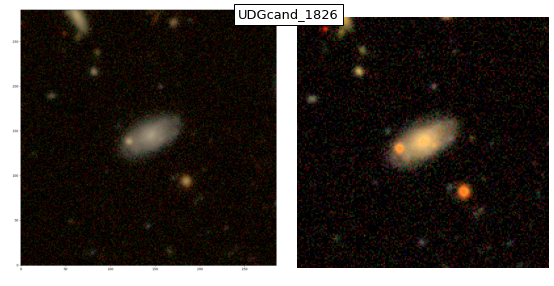

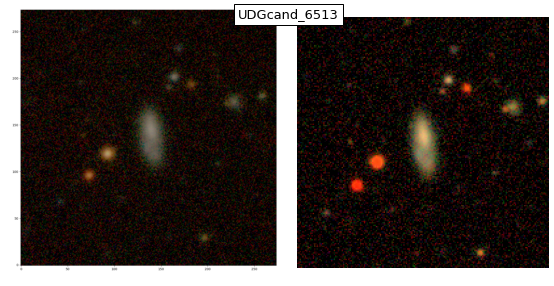

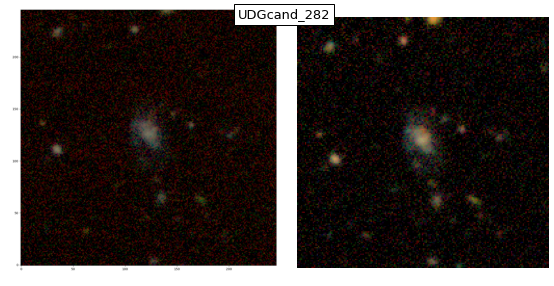

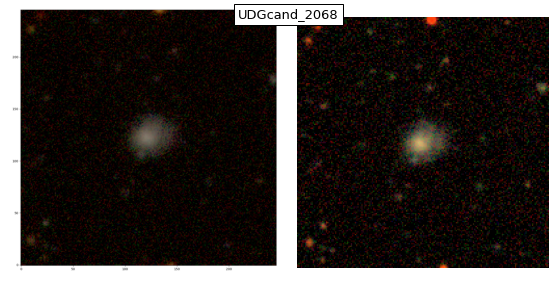

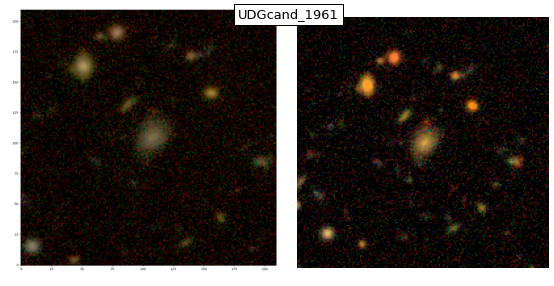

In [29]:
n = 5
random_idc = []
while len(set(random_idc)) < n:
    idx = np.random.randint(0, input_df.shape[0])
    if not idx in set(random_idc):
        random_idc.append(idx)

# this set contains all likely truth objects:
# for name in np.array((input_df)['name'].tolist())[random_idc]:
#     plot_fds_vs_des(name, rgbs, size=1)
    
# this set contains objects votes fluffy, that survive selection cuts, but are not in the likely ground truth:
for name in np.array(df_votes.query('name.isin(@survives_cut_not_fluffy)')['name'].tolist())[random_idc]:
    plot_fds_vs_des(name, rgbs_fluf_no_cat, size=2)

In [35]:
size=15

rgbs = make_rgb(
    base_dir=base_dir,
    input_df=input_df,
    Q=5, 
    stretch=25, 
#     limit=size*size,
)

idc = set([])
rgbvals = []
while len(set(idc)) < size*size:
    random_idx = np.random.randint(0, len(list(rgbs.values())))
    if not random_idx in idc:
        idc.add(random_idx)
        rgbvals.append(list(rgbs.values())[random_idx])

In [ ]:
# use on 2x2 arcmin image to isolate the central object

# shape = list(rgbs.values())[0].shape
# shape[0]/4

# mid = int(shape[0]/2)
# start = int(mid - shape[0]/4)
# end = int(mid + shape[0]/4)

# a = np.array(list(rgbs.values()))
# v = a[0]

# plt.imshow(v[start:end, start:end, :], origin='lower')

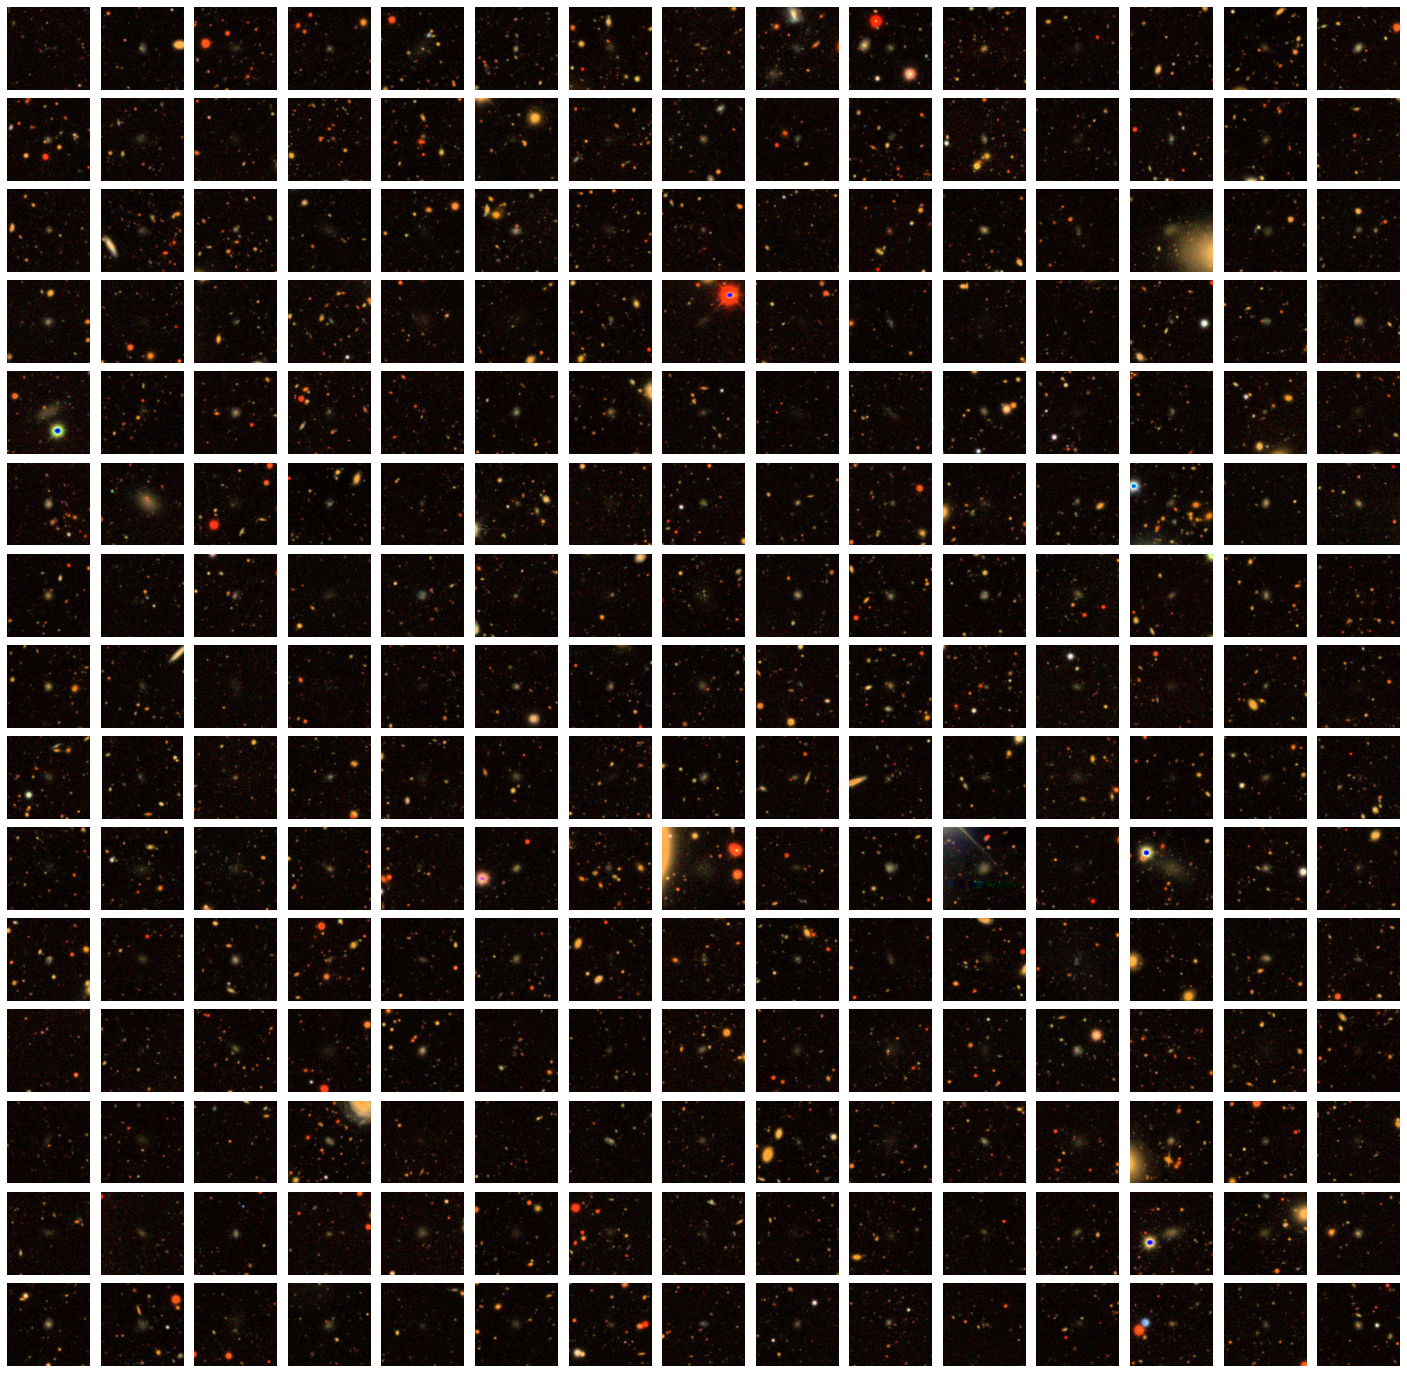

In [36]:
from matplotlib.colors import LogNorm

fig, fr = plt.subplots(size,size, figsize=(25,25), gridspec_kw=dict(wspace=0.1, hspace=0.1))
fr = np.ravel(fr)

for i in range(size*size):
    fr[i].imshow(rgbvals[i], origin='lower')
    fr[i].set_axis_off()
    fr[i].set_xticklabels([])
    fr[i].set_yticklabels([])
    
plt.savefig('./plots/des_lupton - fluf not in catalogue.png', dpi=400, bbox_inches='tight')

## Make Lupton RGB from DES images of likely ground truth targets

In [ ]:
## create rgb arrays
catalogue_rgbs = make_rgb(
    base_dir = 'all-catalogue-1x1arcmin',  # name of dir, as /analysis/image/des/%base_dir%
    Q = 5,
    stretch= 25
)

## extract values to list  [@todo: map DES tile names to names as they are in SpaceFluff]
rgbvals = list(catalogue_rgbs.values())

In [ ]:
## plot
size = 10

fig, fr = plt.subplots(size,size, figsize=(15,15), gridspec_kw=dict(wspace=0.1, hspace=0.1))
fr = np.ravel(fr)

for i in range(size*size):
    fr[i].imshow(rgbvals[i], origin='lower')
    fr[i].set_axis_off()
    fr[i].set_xticklabels([])
    fr[i].set_yticklabels([])
    
plt.savefig('./plots/des_lupton - catalogue.png', dpi=400, bbox_inches='tight')

Name, RA, DEC of each object in DES cutout set `all-catalogue-1x1arcmin`:

In [ ]:
# names, ras, decs = df_votes.query('name.isin(@catalogue_targets)')[['name', 'RA', 'DEC']].values.T

# for name, ra, dec in zip(names, ras, decs):
#     print('{}, {},{}'.format(name, ra, dec))

Copy-paste for posterity:

UDGcand_110, 56.2119216919,-35.7883605957
UDGcand_122, 55.3111953735,-35.4509887695
UDGcand_197, 55.8572998047,-35.229221344
UDGcand_164, 56.2081756592,-35.5354995728
UDGcand_30, 55.3600158691,-35.3796882629
UDGcand_358, 55.4469947815,-36.2249679565
UDGcand_97, 55.6310539246,-35.0248451233
UDGcand_117, 55.8613739014,-35.497844696
UDGcand_50, 56.0367088318,-35.1444816589
UDGcand_149, 55.9851417542,-35.8301315308
UDGcand_98, 55.3455810547,-35.8966178894
UDGcand_108, 55.6970252991,-35.3897895813
UDGcand_336, 50.2844047546,-36.2314758301
UDGcand_331, 49.8690567017,-36.8686332703
UDGcand_114, 55.7587051392,-35.3283157349
UDGcand_372, 55.9284286499,-36.6954803467
UDGcand_111, 56.3158149719,-35.2712059021
UDGcand_68, 55.5466537476,-35.4432411194
UDGcand_120, 55.2824401855,-35.4126091003
UDGcand_298, 49.9762878418,-36.4138832092
UDGcand_3, 55.688835144,-35.4719543457
UDGcand_378, 56.4098396301,-36.8765220642
UDGcand_2805, 53.8798675537,-37.0394592285
UDGcand_3921, 54.5350532532,-33.025718689
UDGcand_1702, 50.85679245,-36.4332923889
UDGcand_6332, 55.0521240234,-35.2887268066
UDGcand_6415, 54.6987304688,-35.7255859375
UDGcand_426, 55.2997283936,-36.0694084167
UDGcand_5704, 51.9623184204,-35.0400238037
UDGcand_2764, 53.45287323,-37.3406028748
UDGcand_5903, 56.7046928406,-34.7794876099
UDGcand_4674, 55.1751174927,-34.1208534241
UDGcand_3471, 56.4537391663,-34.8818321228
UDGcand_3478, 56.205291748,-34.5312843323
UDGcand_6370, 54.0510215759,-35.7463035583
UDGcand_4681, 54.2888526917,-34.2914161682
UDGcand_2260, 51.975944519,-37.5268478394
UDGcand_1045, 49.7165336609,-37.6186332703
UDGcand_6822, 53.0112419128,-36.382068634
UDGcand_4405, 54.6988220215,-34.5563011169
UDGcand_2326, 52.2678947449,-37.3374290466
UDGcand_3605, 54.8843727112,-33.6094017029
UDGcand_685, 53.5976753235,-35.8450126648
UDGcand_3532, 56.233379364,-34.296295166
UDGcand_1441, 56.2275466919,-33.8784408569
UDGcand_780, 53.6720237732,-35.5068740845
UDGcand_5319, 51.7204856873,-36.0857772827
UDGcand_3578, 54.8152580261,-33.9180335999
UDGcand_5130, 52.5645256042,-34.4250564575
UDGcand_2964, 55.5294151306,-34.5645904541
UDGcand_1881, 51.70362854,-33.6964073181
UDGcand_4265, 54.5553207397,-34.7762985229
UDGcand_5663, 51.6526527405,-35.0264587402
UDGcand_5170, 52.4905548096,-34.3830795288
UDGcand_2367, 53.0419692993,-34.2650184631
UDGcand_3198, 55.3619728088,-34.9167861938
UDGcand_3643, 55.1504325867,-33.8044586182
UDGcand_3162, 56.0955429077,-34.6224060059
UDGcand_2693, 57.3918304443,-37.4947471619
UDGcand_2745, 53.6081314087,-37.4844169617
UDGcand_3009, 56.4554595947,-34.4324684143
UDGcand_6759, 52.8611373901,-36.0962867737
UDGcand_6648, 54.4352798462,-35.7036361694
UDGcand_6860, 53.7451171875,-36.1968917847
UDGcand_548, 55.7840042114,-36.9201049805
UDGcand_2516, 53.618927002,-34.9440803528
UDGcand_762, 53.528755188,-35.380027771
UDGcand_3869, 54.8474349976,-33.659992218
UDGcand_4607, 54.5196228027,-34.3829917908
UDGcand_726, 53.7428703308,-35.2583961487
UDGcand_4321, 54.1914405823,-34.413772583
UDGcand_3155, 56.422618866,-33.9960823059
UDGcand_1883, 52.4269790649,-33.1532516479
UDGcand_3014, 55.6079177856,-34.3349685669
UDGcand_5729, 51.7765312195,-35.0054359436
UDGcand_7158, 54.726272583,-35.9861755371
UDGcand_447, 55.6176681519,-36.3763656616
UDGcand_2253, 52.5748252869,-37.2059898376
UDGcand_5708, 51.6470603943,-35.1004676819
UDGcand_2713, 56.8123054504,-37.3650360107
UDGcand_1064, 49.886390686,-37.9017410278
UDGcand_1717, 51.5151138306,-36.9045181274
UDGcand_949, 53.7356987,-35.6876449585
UDGcand_5044, 50.8384819031,-37.1133651733
UDGcand_4562, 54.3129119873,-34.701335907
UDGcand_2373, 53.6686973572,-34.3540725708
UDGcand_6799, 53.9197540283,-36.7435836792
UDGcand_1560, 57.0478973389,-35.196308136
UDGcand_4490, 54.9456748962,-34.6873092651
UDGcand_4237, 54.9273529053,-34.2763824463
UDGcand_2735, 56.4794540405,-37.1809539795
UDGcand_2592, 52.9642944336,-34.8473396301
UDGcand_5095, 50.4837837219,-37.6262016296
UDGcand_2878, 53.7615013123,-37.907787323
UDGcand_5187, 51.7100753784,-34.0405235291
UDGcand_4356, 54.3573532104,-34.3708000183
UDGcand_3822, 54.2437286377,-33.162071228
UDGcand_3779, 54.8873023987,-33.1938247681
UDGcand_784, 54.0074462891,-35.3107261658
UDGcand_4845, 54.5273551941,-34.4150276184
UDGcand_7115, 54.5137367249,-36.7422065735
UDGcand_5457, 52.4633178711,-36.3971214294
UDGcand_1776, 51.3377571106,-36.6807327271
UDGcand_4191, 53.7291946411,-33.2091255188
UDGcand_1048, 49.4515838623,-37.7278709412
UDGcand_5097, 50.9157180786,-37.0949401855
UDGcand_6457, 55.0776138306,-35.137386322
UDGcand_6339, 54.2493896484,-35.1373291016
UDGcand_7116, 54.0340461731,-36.2891426086
UDGcand_5080, 51.261882782,-37.004283905
UDGcand_4211, 53.7622680664,-33.6910858154
UDGcand_1725, 50.3274421692,-36.3646621704
UDGcand_7197, 55.0864257812,-36.7495651245
UDGcand_5387, 51.761177063,-36.0911598206
UDGcand_2214, 52.4293746948,-37.0699386597
UDGcand_5492, 52.7520828247,-35.512676239
UDGcand_7252, 54.8491401672,-36.9490585327
UDGcand_1417, 55.6536102295,-33.276184082
UDGcand_2568, 53.395149231,-34.4668388367
UDGcand_2356, 51.7981452942,-37.4905548096
UDGcand_613, 55.5892982483,-36.3699836731
UDGcand_7053, 54.5354347229,-36.0084648132
UDGcand_1762, 50.7483177185,-36.7659301758
UDGcand_3227, 55.7327804565,-34.225315094
UDGcand_2496, 53.9699516296,-34.2429389954
UDGcand_7219, 55.1395797729,-36.5548439026
UDGcand_5758, 52.099319458,-35.7631759644
UDGcand_3832, 54.1040611267,-33.7278747559
UDGcand_3221, 56.307144165,-34.5639228821
UDGcand_1754, 50.8317375183,-36.3323135376
UDGcand_6748, 53.1326370239,-36.7990226746
UDGcand_4166, 53.8810844421,-33.2399597168
UDGcand_6410, 54.899559021,-35.2980880737
UDGcand_5133, 52.1851119995,-34.0663795471
UDGcand_4474, 54.6512260437,-34.5335044861
UDGcand_5817, 52.7550125122,-35.637714386
UDGcand_3098, 55.8614425659,-34.2449531555
UDGcand_7155, 54.0352210999,-35.986782074
UDGcand_6661, 53.5472297668,-36.7498130798
UDGcand_1599, 50.5979347229,-35.9922866821
UDGcand_3465, 56.2520713806,-34.7437553406
UDGcand_6437, 55.0186958313,-35.0726547241
UDGcand_6350, 55.206943512,-35.3883514404
UDGcand_7259, 54.3614578247,-36.7164993286
UDGcand_3406, 55.9067611694,-34.7768096924
UDGcand_6086, 57.6523857117,-34.899723053
UDGcand_2116, 54.6608009338,-37.3550987244
UDGcand_2296, 52.7242202759,-37.6583709717
UDGcand_4655, 54.4036369324,-34.741645813
UDGcand_1709, 51.054473877,-36.9494552612
UDGcand_927, 53.229511261,-35.1675720215
UDGcand_5716, 51.6391372681,-35.1543617249
UDGcand_5739, 51.9729881287,-35.068813324
UDGcand_4702, 54.6022224426,-34.6486206055
UDGcand_6214, 54.7460365295,-35.7412033081
UDGcand_3568, 54.445980072,-33.4367294312
UDGcand_4635, 54.0734138489,-34.3187065125
UDGcand_5771, 51.7815361023,-35.1348991394
UDGcand_573, 55.5303993225,-36.2306632996
UDGcand_2528, 53.6201705933,-34.4403305054
UDGcand_6621, 54.517124176,-35.2821846008
UDGcand_2365, 53.6916122437,-34.892490387
UDGcand_655, 53.7528419495,-35.4221229553
UDGcand_4842, 55.2243385315,-34.288192749
UDGcand_5374, 52.0379066467,-36.9367485046
UDGcand_2872, 53.4324150085,-37.1163063049
UDGcand_2622, 53.9499855042,-34.6997375488
UDGcand_405, 55.8587417603,-36.5741195679
UDGcand_561, 55.9664344788,-36.8244972229
UDGcand_485, 55.7543144226,-36.7477760315
UDGcand_3142, 55.3952674866,-34.3258361816
UDGcand_4740, 54.8934326172,-34.0900535583
UDGcand_948, 53.5659713745,-35.6523971558
UDGcand_4429, 54.6617164612,-34.2845840454
UDGcand_3840, 54.9394073486,-33.1647834778
UDGcand_4802, 55.1182975769,-34.7861785889
UDGcand_560, 55.7149238586,-36.922504425
UDGcand_6102, 56.5457801819,-34.3528060913
UDGcand_5706, 51.668170929,-35.1853103638
UDGcand_4072, 53.5915107727,-33.7580413818
UDGcand_1761, 51.4506454468,-36.7887535095
UDGcand_818, 54.0009040833,-35.9357376099
UDGcand_1344, 55.2884063721,-33.2876930237
UDGcand_5541, 51.9202766418,-35.0260162354
UDGcand_3476, 55.6862602234,-34.5956382751
UDGcand_906, 53.0340843201,-35.0201148987
UDGcand_657, 53.6810073853,-35.5210609436
UDGcand_5271, 51.6452522278,-34.498085022
UDGcand_6554, 54.3629226685,-35.3057632446
UDGcand_6257, 54.7311820984,-35.2370910645
UDGcand_6518, 54.0423545837,-35.6712303162
UDGcand_5180, 52.7455825806,-34.6932983398
UDGcand_5111, 51.5188865662,-37.1087493896
UDGcand_7225, 55.0605392456,-36.6135025024
UDGcand_3459, 55.4162521362,-34.3223342896
UDGcand_6831, 53.6024513245,-35.9680671692
UDGcand_5464, 51.8689956665,-36.7142562866
UDGcand_6417, 54.161239624,-35.6113510132
UDGcand_1056, 49.9105834961,-37.511631012
UDGcand_3526, 55.8359451294,-34.2107048035
UDGcand_5183, 52.3776435852,-34.4024238586
UDGcand_5992, 56.68309021,-34.3943519592
UDGcand_1149, 55.537322998,-33.6824264526
UDGcand_892, 53.431224823,-35.7332000732
UDGcand_3977, 53.6501541138,-33.7073478699
UDGcand_975, 53.316783905,-35.5975494385
UDGcand_3841, 54.6376457214,-33.6632995605
UDGcand_985, 53.5293884277,-35.4772071838
UDGcand_6190, 54.2380256653,-35.8365325928
UDGcand_436, 55.5630989075,-36.1291694641
UDGcand_4008, 53.4327201843,-33.2345352173
UDGcand_1664, 51.5055274963,-36.7062988281
UDGcand_2974, 55.6718139648,-34.6798553467
UDGcand_6699, 53.4926261902,-36.191078186
UDGcand_777, 53.9472923279,-35.3618621826
UDGcand_3726, 54.9325141907,-33.7767753601
UDGcand_735, 53.6185150146,-35.8104248047
UDGcand_6421, 54.9852867126,-35.6223564148
UDGcand_886, 53.0228919983,-35.8266448975
UDGcand_6250, 55.1890220642,-35.5020523071
UDGcand_2824, 53.7146530151,-36.9776535034
UDGcand_4621, 54.6312408447,-34.7748184204
UDGcand_3063, 55.5055656433,-34.9252700806
UDGcand_5363, 52.5952720642,-36.2246513367
UDGcand_6655, 52.9488792419,-36.3477630615
UDGcand_6242, 55.2133674622,-35.1480560303
UDGcand_5586, 51.8254890442,-34.9958686829
UDGcand_7146, 54.3144302368,-36.8422546387
UDGcand_1141, 49.18176651,-37.7863616943
UDGcand_6733, 53.3430252075,-36.0801200867
UDGcand_5048, 50.7553100586,-37.4211540222
UDGcand_1765, 50.5113868713,-36.2942008972

## Plot images of objects for which users are extremely sure they're fluffies:

In [ ]:
n = rgbs_fluf_no_cat.keys()

In [ ]:
f90 = df_votes.query('name.isin(@n) & `T1 % fluffy` >= 90 & `T0 % galaxy` >= 90')['name'].tolist()

In [ ]:
size = 8

fig, fr = plt.subplots(size,size, figsize=(15,15), gridspec_kw=dict(wspace=0.1, hspace=0.1))
fr = np.ravel(fr)
t = 160
for i in range(size*size):
    fr[i].imshow(rgbs_fluf_no_cat[f90[i]][t:-t, t:-t, :], origin='lower')
    fr[i].set_axis_off()
    fr[i].set_xticklabels([])
    fr[i].set_yticklabels([])
    
# plt.savefig('./plots/des_lupton - catalogue.png', dpi=400, bbox_inches='tight')

In [ ]:
plot_image_grid(
    df_votes.query('name.isin(@catalogue_targets)'),
    4, 4
)